## Atlas preprocessing steps to convert MRI scans to atlas specific correlation matrices

This notebook contains the preprocessing steps to convert MRI scans to atlas specific correlation matrices. The steps are as follows:

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import nilearn
import pydicom as dicom

## DICOM to NIFTI conversion

First, if you have not already, you will need to have your images in NIFTI format (.nii or .nii.gz). You can convert the DICOM images (.dcm) to NIFTI either by:
- Using the dicom2nifti package as described below
- Using the dicom2niix package via cmd line (e.g. using : dcm2niix -f %p_%s -g y DIRECTORY_PATH)
- Using the dicom2bids package via cmd line (Recommended)

In [2]:
import dicom2nifti
directory_scan = 'RAW_PPMI/3102/ep2d_RESTING_STATE/2013-02-24_10_49_22.0/I378209/' # example of path of images of a scan
dicom2nifti.convert_directory(directory_scan, 'nifti_series', compression=True, reorient=True) # convert to nifti

## Atlas preprocessing
We are now ready to get the atlas parcellations for our NIFTI files

In [4]:
# Insert your path to the nifti file here (.nii or .nii.gz)
nifti_path = 'PATH_TO_NIFTI_FILE'

In [8]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker

## CORTICAL ##
dataset = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm", symmetric_split=True)
atlas_filename = dataset.maps
labels = dataset.labels

masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
    labels=labels,
    resampling_target="labels",
)

time_series = masker.fit_transform(nifti_path)


## SUBCORTICAL ##
dataset_sub = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm", symmetric_split=False)
atlas_filename_sub = dataset_sub.maps
labels_sub = dataset_sub.labels

masker_sub = NiftiLabelsMasker(
    labels_img=atlas_filename_sub,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
    labels=labels_sub,
)

time_series_sub = masker_sub.fit_transform(nifti_path)

# Concatenate the two time series together
time_series_concat = np.concatenate((time_series, time_series_sub), axis=1)
print("Shape of time series for the cortical atlas: ", time_series.shape) # Expecting to be (n_time_points, 96)
print("Shape of time series for the subcortical atlas: ", time_series_sub.shape) # Expecting to be (n_time_points, 21)
print("Shape of time series for the cortical and subcortical atlas: ", time_series_concat.shape) # Expecting to be (n_time_points, 117)

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]0.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]0.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Shape of time series for the cortical atlas:  (210, 96)
Shape of time series for the subcortical atlas:  (210, 21)
Shape of time series for the cortical and subcortical atlas:  (210, 117)


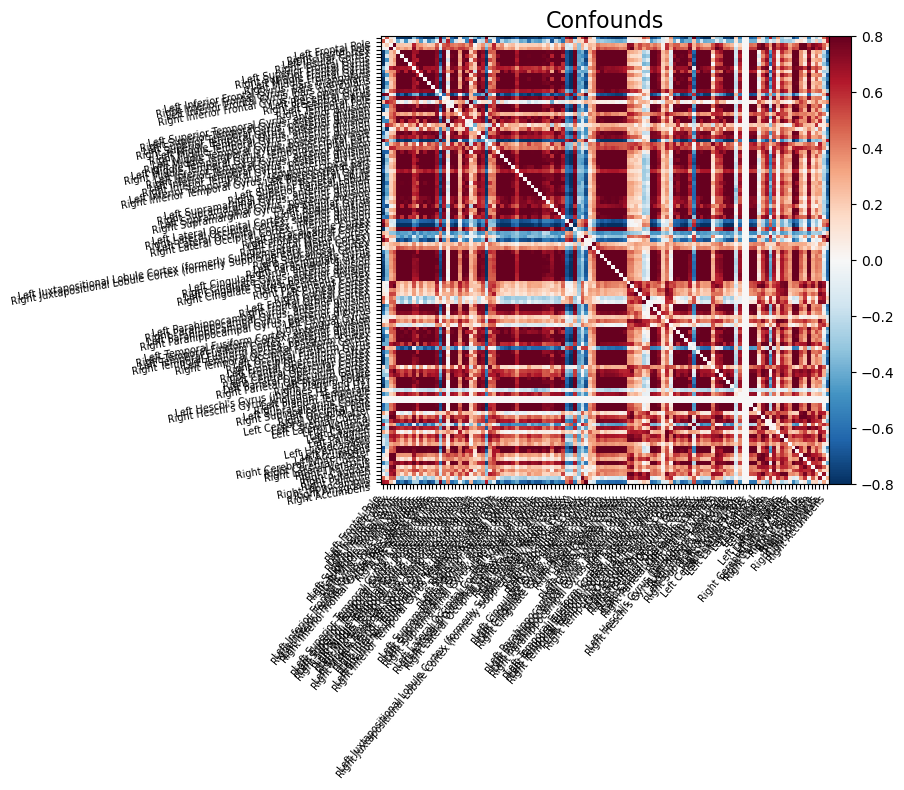

In [9]:
from nilearn.connectome import ConnectivityMeasure

# Compute correlation matrices
correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([time_series_concat])[0]

# Get correlation matrix for cortical atlas only
correlation_measure_cortical = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix_cortical = correlation_measure_cortical.fit_transform([time_series])[0]

# Plot the correlation matrix
from nilearn import plotting
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the first label
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    vmax=0.8,
    vmin=-0.8,
    title="Confounds",
    labels=labels[1:] + labels_sub[1:],
)

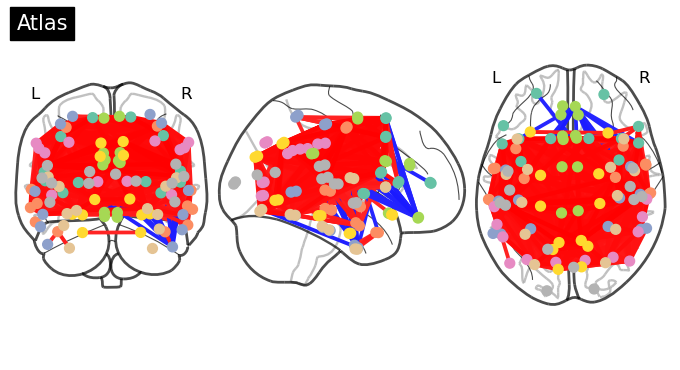

In [10]:
# Plot of the cortical atlas with connectome 
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)
plotting.plot_connectome(
    correlation_matrix_cortical,
    coordinates,
    edge_threshold="80%",
    title="Atlas",
)